<a href="https://colab.research.google.com/github/AreebAhmad-02/Embedding-Models-Finetuning/blob/main/Fine_tuning_Embedding_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## imports and install

In [ ]:
!pip install llama_index -q -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.8/326.8 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.0 MB/s eta 0:00:00


In [ ]:
import json

from llama_index.core import VectorStoreIndex, SimpleDirectoryReader,StorageContext,load_index_from_storage
from llama_index.core.node_parser import SimpleNodeParser
from llama_index.core.schema import MetadataMode
from llama_index.core import Settings

In [ ]:
TRAIN_CORPUS_FPATH_SENTENCE_SPLIT = './corpus/train_corpus_sentence_split.json'
EVAL_CORPUS_FPATH_SENTENCE_SPLIT = './corpus/eval_corpus_sentence_split.json'



In [ ]:
TRAIN_FILES = ["/content/data/batch1preprocessed_file.txt","/content/data/batch2preprocessed_file.txt"]
VAL_FILES = ['/content/data/batch0preprocessed_file.txt']

TRAIN_CORPUS_FPATH = './corpus/train_corpus.json'
VAL_CORPUS_FPATH = './corpus/val_corpus.json'

In [ ]:
TRAIN_FILES = ["/content/data/batch1preprocessed_file.txt","/content/data/batch2preprocessed_file.txt","/content/data/batch0preprocessed_file.txt"]
VAL_CORPUS_FPATH = ""
TRAIN_CORPUS_FPATH = './corpus/train_corpus.json'
VAL_CORPUS_FPATH = './corpus/val_corpus.json'

#Chunking

## simple chunking splitting

In [ ]:
def load_corpus(files, verbose=False):
    if verbose:
        print(f"Loading files {files}")

    reader = SimpleDirectoryReader(input_files=files)
    docs = reader.load_data()
    if verbose:
        print(f'Loaded {len(docs)} docs')

    parser = SimpleNodeParser.from_defaults()
    nodes = parser.get_nodes_from_documents(docs, show_progress=verbose)

    if verbose:
        print(f'Parsed {len(nodes)} nodes')

    corpus = {node.node_id: node.get_content(metadata_mode=MetadataMode.NONE) for node in nodes}
    return corpus

In [ ]:
train_corpus = load_corpus(TRAIN_FILES, verbose=True)
val_corpus = load_corpus(VAL_FILES, verbose=True)

Loading files ['/content/batch1preprocessed_file.txt', '/content/batch2preprocessed_file.txt']
Loaded 2 docs


Parsing nodes:   0%|          | 0/2 [00:00<?, ?it/s]

Parsed 66 nodes
Loading files ['/content/data/preprocessed_file.txt']
Loaded 1 docs


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Parsed 30 nodes


In [ ]:
with open(TRAIN_CORPUS_FPATH, 'w+') as f:
    json.dump(train_corpus, f)

with open(VAL_CORPUS_FPATH, 'w+') as f:
    json.dump(val_corpus, f)

## Sentence split chunking using

### sentnece spliting simple

In [ ]:
from llama_index.core.node_parser import SentenceSplitter


def load_corpus_sentence_splitter(files, verbose=False):
    if verbose:
        print(f"Loading files {files}")

    reader = SimpleDirectoryReader(input_files=files)
    docs = reader.load_data()
    if verbose:
        print(f'Loaded {len(docs)} docs')


    splitter = SentenceSplitter(
    chunk_size=524,
    chunk_overlap=20,)
    nodes = splitter.get_nodes_from_documents(docs, show_progress=verbose)

    if verbose:
        print(f'Parsed {len(nodes)} nodes')

    corpus = {node.node_id: node.get_content(metadata_mode=MetadataMode.NONE) for node in nodes}
    return corpus


In [ ]:
# train_corpus_sentence_split = load_corpus_sentence_splitter(TRAIN_FILES, verbose=True)
val_corpus_sentence_split = load_corpus_sentence_splitter(VAL_FILES, verbose=True)

Loading files ['/content/data/batch0preprocessed_file.txt']
Loaded 1 docs


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Parsed 52 nodes


In [ ]:
# with open(TRAIN_CORPUS_FPATH_SENTENCE_SPLIT, 'w+') as f:
#     json.dump(train_corpus_sentence_split, f)

with open(EVAL_CORPUS_FPATH_SENTENCE_SPLIT, 'w+') as f:
    json.dump(val_corpus_sentence_split, f)

### Customizing the above function to split it into training and testing corpuses

In [ ]:
from llama_index.core.node_parser import SentenceSplitter
from sklearn.model_selection import train_test_split


def load_corpus_sentence_splitter_split_train_test(files, test_size=0.2, random_state=None, verbose=False):
    if verbose:
        print(f"Loading files {files}")

    reader = SimpleDirectoryReader(input_files=files)
    docs = reader.load_data()
    if verbose:
        print(f'Loaded {len(docs)} docs')

    splitter = SentenceSplitter(
        chunk_size=524,
        chunk_overlap=20
    )
    nodes = splitter.get_nodes_from_documents(docs, show_progress=verbose)

    if verbose:
        print(f'Parsed {len(nodes)} nodes')

    # Split nodes into training and testing sets
    train_nodes, test_nodes = train_test_split(nodes, test_size=test_size, random_state=random_state)

    if verbose:
        print(f'Training nodes: {len(train_nodes)}, Testing nodes: {len(test_nodes)}')

    # Create the corpus dictionary for training and testing sets
    train_corpus = {node.node_id: node.get_content(metadata_mode=MetadataMode.NONE) for node in train_nodes}
    test_corpus = {node.node_id: node.get_content(metadata_mode=MetadataMode.NONE) for node in test_nodes}

    return train_corpus, test_corpus




In [ ]:

train_corpus_sentence_split, val_corpus_sentence_split = load_corpus_sentence_splitter_split_train_test(TRAIN_FILES, test_size=0.2, random_state=42, verbose=True)


# Now you have train_corpus and test_corpus
print("Train corpus:", train_corpus_sentence_split)
print("Test corpus:", val_corpus_sentence_split)

Loading files ['/content/data/batch1preprocessed_file.txt', '/content/data/batch2preprocessed_file.txt', '/content/data/batch0preprocessed_file.txt']
Loaded 3 docs


Parsing nodes:   0%|          | 0/3 [00:00<?, ?it/s]

Parsed 171 nodes
Training nodes: 136, Testing nodes: 35
Train corpus: {'11c54093-d115-415e-a08c-ebd7285544af': '(d) Exclusion of Certain Sales of Real Property. For purposes of this Article 28, gross\nreceipts as defined in Section 952.3 shall not include receipts from any sales of real property with\nrespect to which the Real Property Transfer Tax imposed by Article 12-C has been paid to the City.\n(e) For only so long as and to the extent that the City is prohibited from imposing the tax under\nthis Article 28, the following persons shall be exempt from the homelessness gross receipts tax:\n(1) Banks and financial corporations exempt from local taxation under Article XIII,\nSection 27 of the California Constitution and Revenue and Taxation Code Section 23182;\n(2) Insurance companies exempt from local taxation under Article XIII, Section 28 of\nthe California Constitution;\n(3) Persons engaging in business as a for-hire motor carrier of property under Revenue\nand Taxation Code Secti

In [ ]:
with open(TRAIN_CORPUS_FPATH_SENTENCE_SPLIT, 'w+') as f:
    json.dump(train_corpus_sentence_split, f)

with open(EVAL_CORPUS_FPATH_SENTENCE_SPLIT, 'w+') as f:
    json.dump(val_corpus_sentence_split, f)

We do a very naive train/val split by having the
.


## importings and inporting data

#  Initilazing HuggingFace LLM

In [1]:
!pip install llama-index-llms-huggingface -q -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.9 MB/s eta 0:00:00


In [2]:
%pip install -q -U git+https://github.com/huggingface/transformers.git
%pip install accelerate -q -U
%pip install -i https://pypi.org/simple/ bitsandbytes -q
%pip install sentence-transformers -q
%pip install --upgrade transformers -q -U



  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 5.1 MB/s eta 0:00:00


## quantization Configuration and initializing LLM zephyr-7b-beta

In [3]:
import torch
from transformers import BitsAndBytesConfig
from llama_index.core.prompts import PromptTemplate
from llama_index.llms.huggingface import HuggingFaceLLM


import os
import warnings

warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [4]:
# use this code when using GPU
quantization_conf = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)


#We recreate template (or messages) and ensure that they have the correct format, as per,
#https://github.com/run-llama/llama_index/issues/9277#issuecomment-1837545398 for zephyr-7b-beta

def messages_to_prompt(messages):
    prompt = ""
    for message in messages:
        if message.role == 'system':
            prompt += f"<|system|>\n{message.content}</s>\n"
        elif message.role == 'user':
            prompt += f"<|user|>\n{message.content}</s>\n"
        elif message.role == 'assistant':
            prompt += f"<|assistant|>\n{message.content}</s>\n"

    # ensure we start with a system prompt, insert blank if needed
    if not prompt.startswith("<|system|>\n"):
        prompt = "<|system|>\n</s>\n" + prompt

    # add final assistant prompt
    prompt = prompt + "<|assistant|>\n"
    return prompt

### LLM for GPU settings

In [7]:
def huggingface_llm(model_name="HuggingFaceH4/zephyr-7b-beta",
                    tokenizer_name="HuggingFaceH4/zephyr-7b-beta",
                    context_window=4000,
                    max_new_tokens=256,
                    quantization_config = quantization_conf
                   ):
    llm = HuggingFaceLLM(
        model_name=model_name,
        tokenizer_name=tokenizer_name,
        query_wrapper_prompt=PromptTemplate("<|system|>\n</s>\n<|user|>\n{query_str}</s>\n<|assistant|>\n"),
        context_window=context_window,
        max_new_tokens=max_new_tokens,
        model_kwargs={"quantization_config": quantization_config},
        # tokenizer_kwargs={},
        generate_kwargs={"temperature": 0.7, "top_k": 50, "top_p": 0.95},
        messages_to_prompt=messages_to_prompt,
        device_map="auto",
    )

    return llm

llm = huggingface_llm()

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

### LLM  with CPU Setting

In [ ]:
%pip install llama-index-llms-huggingface-api -q -U


In [ ]:
def huggingface_llm(model_name="stabilityai/stable-code-3b",
                    tokenizer_name="stabilityai/stable-code-3b",
                    context_window=3900,
                    max_new_tokens=256,
                    # quantization_config = quantization_conf
                   ):
    llm = HuggingFaceLLM(
        model_name=model_name,
        tokenizer_name=tokenizer_name,
        query_wrapper_prompt=PromptTemplate("<|system|>\n</s>\n<|user|>\n{query_str}</s>\n<|assistant|>\n"),
        context_window=context_window,
        max_new_tokens=max_new_tokens,
        # model_kwargs={"quantization_config": quantization_config},
        # tokenizer_kwargs={},
        generate_kwargs={ "top_k": 50, do_sample=True},
        messages_to_prompt=messages_to_prompt,
        device_map="cpu",
    )

    return llm

llm = huggingface_llm()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Generate synthetic data


## imports and initializing data

In [8]:
import json
import re
import uuid

In [9]:
TRAIN_CORPUS_FPATH_SENTENCE_SPLIT = './corpus/train_corpus_sentence_split.json'
EVAL_CORPUS_FPATH_SENTENCE_SPLIT = './corpus/eval_corpus_sentence_split.json'

In [11]:
TRAIN_QUERIES_FPATH = './data/train_queries.json'
TRAIN_RELEVANT_DOCS_FPATH = './data/train_relevant_docs.json'

VAL_QUERIES_FPATH = './data/val_queries.json'
VAL_RELEVANT_DOCS_FPATH = './data/val_relevant_docs.json'

In [10]:
with open(TRAIN_CORPUS_FPATH_SENTENCE_SPLIT, 'r+') as f:
    train_corpus = json.load(f)


with open(EVAL_CORPUS_FPATH_SENTENCE_SPLIT, 'r+') as f:
    val_corpus = json.load(f)

In [12]:
from typing import Dict, List, Tuple

from llama_index.core.bridge.pydantic import BaseModel
from llama_index.core.llms.utils import LLM
from llama_index.core.schema import MetadataMode, TextNode
from tqdm import tqdm


## Generating QA Embedding Pair

In [ ]:
class EmbeddingQAFinetuneDataset(BaseModel):
    """Embedding QA Finetuning Dataset.

    Args:
        queries (Dict[str, str]): Dict id -> query.
        corpus (Dict[str, str]): Dict id -> string.
        relevant_docs (Dict[str, List[str]]): Dict query id -> list of doc ids.

    """

    queries: Dict[str, str]  # dict id -> query
    corpus: Dict[str, str]  # dict id -> string
    relevant_docs: Dict[str, List[str]]  # query id -> list of doc ids
    mode: str = "text"

    @property
    def query_docid_pairs(self) -> List[Tuple[str, List[str]]]:
        """Get query, relevant doc ids."""
        return [
            (query, self.relevant_docs[query_id])
            for query_id, query in self.queries.items()
        ]

    def save_json(self, path: str) -> None:
        """Save json."""
        with open(path, "w") as f:
            json.dump(self.dict(), f, indent=4)

    @classmethod
    def from_json(cls, path: str) -> "EmbeddingQAFinetuneDataset":
        """Load json."""
        with open(path) as f:
            data = json.load(f)
        return cls(**data)


DEFAULT_QA_GENERATE_PROMPT_TMPL = """\
Context information is below.

---------------------
{context_str}
---------------------

Given the context information and no prior knowledge.
generate only questions based on the below query.

You are a Teacher/ Professor. Your task is to setup \
{num_questions_per_chunk} questions for an upcoming \
quiz/examination. The questions should be diverse in nature \
across the document. Restrict the questions to the \
context information provided."
"""
# generate queries as a convenience function

def generate_qa_embedding_pairs(
    node_dict,
    llm: LLM,
    qa_generate_prompt_tmpl: str = DEFAULT_QA_GENERATE_PROMPT_TMPL,
    num_questions_per_chunk: int = 2,
) -> EmbeddingQAFinetuneDataset:
    """Generate examples given a set of nodes."""


    queries = {}
    relevant_docs = {}
    for node_id, text in tqdm(node_dict.items()):
        query = qa_generate_prompt_tmpl.format(
            context_str=text, num_questions_per_chunk=num_questions_per_chunk
        )
        response = llm.complete(query)

        result = str(response).strip().split("\n")
        questions = [
            re.sub(r"^\d+[\).\s]", "", question).strip() for question in result
        ]
        questions = [question for question in questions if len(question) > 0][
            :num_questions_per_chunk
        ]

        num_questions_generated = len(questions)
        if num_questions_generated < num_questions_per_chunk:
            warnings.warn(
                f"Fewer questions generated ({num_questions_generated}) "
                f"than requested ({num_questions_per_chunk})."
            )

        for question in questions:
            question_id = str(uuid.uuid4())
            queries[question_id] = question
            relevant_docs[question_id] = [node_id]

        print(questions)

    # construct dataset
    return EmbeddingQAFinetuneDataset(
        queries=queries, corpus=node_dict, relevant_docs=relevant_docs
    )

In [ ]:
train_dataset = generate_qa_embedding_pairs(train_corpus, llm)

100%|██████████| 119/119 [28:05<00:00, 14.17s/it]


In [ ]:
train_dataset.save_json("trained_synthetic_dataset.json")

In [ ]:
train_synthetic_dataset = EmbeddingQAFinetuneDataset.from_json("/content/trained_synthetic_dataset.json")

In [ ]:
# generating evaluation synthetic data set
eval_dataset = generate_qa_embedding_pairs(val_corpus, llm)

  0%|          | 0/52 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:540: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:545: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
  2%|▏         | 1/52 [00:29<25:29, 29.99s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the purpose of the Ordinance presented in the context information, and what actions does it propose to take?', 'Who are the sponsors of this Ordinance, and what is the proposed timeline for its implementation?']


  4%|▍         | 2/52 [00:43<16:42, 20.05s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the purpose of Ordinance No. 153-22, and what actions does it propose to take in relation to the County Transportation Authority and sales tax?', "How does the proposed Ordinance amend the Business and Tax Regulations Code, and what is the duration and rate of the local transactions and use tax that it seeks to continue in effect? Additionally, what is the amount by which the Transportation Authority's appropriations limit would be increased, and for how long? Finally, what is the role of limited tax bonds in this proposal, and what is the basis for the Transportation Authority's determination under the California Environmental Quality Act?"]


  6%|▌         | 3/52 [01:05<17:25, 21.35s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is Proposition B, and how was it approved by the voters in California in 1989?', "What is the New Transportation Expenditure Plan adopted as part of Proposition K in 2003, and how does it differ from Proposition B's Transportation Expenditure Plan?"]


  8%|▊         | 4/52 [01:29<17:42, 22.13s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the purpose of amending Business and Tax Regulations Code Article 14 and Division 12.5 of the California Public Utilities Code?', 'a) To increase the tax rate from 0.5% to 1.0%']


 10%|▉         | 5/52 [01:52<17:37, 22.51s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the purpose of the Tax imposed by Article 14, and where will the proceeds be spent?', 'What is the definition of "Authority" and "District" in the context of Article 14? What is the significance of these terms in relation to the Tax?']


 12%|█▏        | 6/52 [02:15<17:22, 22.65s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the purpose of the ordinance being considered by the Board of Supervisors, as outlined in the context information?', 'What is the role of the Expenditure Plan Advisory Committee in relation to the proposed ordinance?']


 13%|█▎        | 7/52 [02:25<13:51, 18.48s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['How does the proposed New Transportation Expenditure Plan aim to achieve its purposes, and what provisions are included to accomplish these goals?', 'What similarities and differences are there between the proposed transactions and use tax in San Francisco and the Sales and Use Tax Law of California? How will the tax be administered and collected by the State Board of EqualizationCalifornia Department of Tax and Fee Administration? What measures are in place to minimize the cost of collecting the tax and minimize the burden of recordkeeping for those subject to taxation?']


 15%|█▌        | 8/52 [02:32<11:00, 15.01s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the purpose of the tax proposed in this ordinance, and what projects will it fund? (refer to sections (g) and (h))', 'What is the role of the Authority in administering the tax and delivering transportation improvements, and what powers does it have? (refer to section SEC. 1404)']


 17%|█▋        | 9/52 [02:56<12:38, 17.64s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the operative date for the implementation of the Tax and the amendments passed in the November 8, 2022 election, as outlined in Section 1405?', 'What is the rate of the Transactions Tax, as specified in Section 1406?']


 19%|█▉        | 10/52 [03:02<09:56, 14.20s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the rate of the use tax imposed in this district, and when does it take effect? (SEC. 1408)', 'How will the place of consumption be determined for retail sales made by a retailer without a permanent place of business in California? (SEC. 1407)']


<ipython-input-22-e71f53699b51>:82: UserWarning: Fewer questions generated (1) than requested (2).
  warnings.warn(
 21%|██        | 11/52 [03:26<11:38, 17.04s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In implementing the provisions of Part 1 (commencing with Section 6001) of Division 2 of the California Revenue and Taxation Code, where should the name of the Authority be substituted instead of the State of California? (a) Whenever the State of California is named or referred to as the taxing agency, (b) When the result of that substitution would require action to be taken by or against the Authority or any agency, officer, or employee thereof rather than by or against the State Board of EqualizationCalifornia Department of Tax and Fee Administration, in performing the functions incident to the administration or operation of this ordinance Article 14, (c) The substitution shall not be made when the word "State" is used as part of the title of the State Controller, the State Treasurer, the State Board of Control, the State Board of Equalization, the State Treasury, or the Constitution of the State of California, or (d) The substitution shall not be made in those sections, including,

 23%|██▎       | 12/52 [03:38<10:20, 15.51s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Question 1:', 'Explain the significance of Subsection (b) in the context information provided. How does it impact retailers engaged in business in the District, and what are the criteria for a retailer to be considered engaged in business in the District?']


 25%|██▌       | 13/52 [04:01<11:35, 17.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


["Question 1: (2) Sales of property to be used outside the District which is shipped to a point outside the District, pursuant to the contract of sale, by delivery to such point by the retailer or the retailer's agent, or by delivery by the retailer to a carrier for shipment to a consignee at such point. For the purposes of this paragraph (b)(2), delivery to a point outside the District shall be satisfied:", 'a) With respect to vehicles (other than commercial vehicles) subject to registration pursuant to Chapter 1 (commencing with Section 4000) of Division 3 of the California Vehicle Code, aircraft licensed in compliance with Section 21411 of the California Public Utilities Code, and undocumented vessels registered under Chapter 2 of Division 3.5 (commencing with Section 98509840) of the California Vehicle Code by registration to an out-of-District address and by a declaration under penalty of perjury, signed by the buyer, stating that such address is, in fact, his/her principal place 

 27%|██▋       | 14/52 [04:18<11:04, 17.49s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Question 1:', 'Explain the meaning of the term "exempted" as used in subsection (c) of the context information provided. How does this exemption differ from the exemptions provided in Sections 6366 and 6366.1 of the California Revenue and Taxation Code? Provide examples of the types of tangible personal property that are exempted under this subsection.']


 29%|██▉       | 15/52 [04:29<09:41, 15.72s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Question 1:', 'Explain the difference between transactions tax and use tax, and how they are related in the context of the provided text material. Additionally, provide an example of a situation where a person may be able to claim a credit against use tax based on transactions tax paid.']


 31%|███       | 16/52 [04:52<10:44, 17.90s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the total principal amount that can be borrowed through the tax imposed by Article 14? (a) $1,880,00,000 (b) $1,910,000,000 (c) $2,000,000,000 (d) $2,100,000,000', 'How should the proceeds from the tax imposed by Article 14 be used? (a) For the projects and purposes set forth in the New Transportation Expenditure Plan approved by voters in 2003 and its updates and revisions (b) For the projects and purposes set forth in the 2022 Transportation Expenditure Plan and any updates or revisions to such Plan, as well as for interest and principal on bonds and administration costs (c) For any purpose deemed necessary by the Board of Supervisors (d) For the projects and purposes set forth in the New Transportation Expenditure Plan approved by voters in 2003, as well as for interest and principal on bonds and administration costs.']


 33%|███▎      | 17/52 [05:16<11:23, 19.52s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the condition for allocation of funds by the Authority mentioned in the context information?', 'What is the appropriations limit for the Authority for fiscal year 2003-04 and each year thereafter, as stated in the context information?']


 35%|███▍      | 18/52 [05:27<09:42, 17.13s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the significance of Section 1418 in the context of this ordinance? How does it affect the validity of the provisions in Article 14 and Part 1.6 of Division 2 of the California Revenue and Taxation Code?', 'What is the purpose of Section 1419 in this ordinance? How does it prevent legal action against the State of California or the Authority in relation to the collection of taxes under this ordinance and Part 1.6 of Division 2 of the California Revenue and Taxation Code?']


 37%|███▋      | 19/52 [05:49<10:16, 18.69s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the purpose of the 2022 Transportation Expenditure Plan, and how long is it intended to be implemented over?', 'What major categories of transportation improvements are included in the 2022 Transportation Expenditure Plan, and what specific benefits do they aim to provide?']


 38%|███▊      | 20/52 [06:13<10:41, 20.04s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['How was equity prioritized in the development of the 2022 Transportation Expenditure Plan?', 'What types of transportation investments will be prioritized for funding through the 2022 Sales Tax, as outlined in the transportation expenditure plan?']


 40%|████      | 21/52 [06:36<10:53, 21.07s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


["How does the SFTP 2050 align with regional trends and available funding to address changing needs in San Francisco's transportation system?", "What are the goals of ConnectSF and the SFTP 2050, and how do they contribute to the overall vision for San Francisco's transportation system as outlined in the SFTP 2050?"]


 42%|████▏     | 22/52 [07:00<10:55, 21.86s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the purpose of the 2022 Transportation Expenditure Plan, and why is the adoption of a sales tax ordinance necessary for its implementation? (Section 1: Introduction)', 'What policies and administration guidelines are outlined in Section 2: General Provisions of the 2022 Transportation Expenditure Plan?']


 44%|████▍     | 23/52 [07:12<09:11, 19.01s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['How does the 2022 Transportation Expenditure Plan differ from the Proposition K Expenditure Plan adopted in 2003? What is the duration of the 2022 Transportation Expenditure Plan and at what rate will the sales tax be imposed?', 'What are the two scenarios for revenue projections under the 2022 Transportation Expenditure Plan, and how do they differ in terms of average growth rate and inflation-based discount rate? Which scenario corresponds to Priority 1 funding levels, and what is the estimated total revenue level for this scenario?']


 46%|████▌     | 24/52 [07:20<07:17, 15.61s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What conditions must be met for 2022 Sales Tax funds to be spent outside the territorial limits of San Francisco, as outlined in the context information?', 'What is the definition of a "quantifiable benefit" in relation to the expenditure of 2022 Sales Tax funds outside of San Francisco, as described in the context information? How is this benefit measured?']


 48%|████▊     | 25/52 [07:43<08:05, 17.97s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the role of the San Francisco County Transportation Authority in administering the funds from the Proposition K sales tax and the new Proposition _ sales tax?', 'What is the maximum amount that can be used for administration costs from the annual net amount of revenues raised by the 2022 Sales Tax, as outlined in Public Utilities Code Section 131107?']


 50%|█████     | 26/52 [08:07<08:30, 19.63s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the National Environmental Policy Act (NEPA) and how does it relate to the approval and implementation of projects funded by the 2022 Sales Tax?', 'What is the California Environmental Quality Act (CEQA) and how does it apply to projects funded by the 2022 Sales Tax?']


 52%|█████▏    | 27/52 [08:20<07:21, 17.66s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Analyze the Transportation Expenditure Plan presented in Table 1 and calculate the percentage of funding allocated to major transit projects under Proposition 2. What are the specific projects included in this category and how much funding is allocated to each?', 'Compare and contrast the funding allocated to transit maintenance and enhancements in Section B of the Transportation Expenditure Plan. Which mode of transportation receives the most funding for maintenance and why? How much funding is allocated to each specific mode of transportation, and what specific projects are included in this category? Additionally, what is the total amount allocated to transit enhancements, and which specific projects fall under this category?']


 54%|█████▍    | 28/52 [08:31<06:17, 15.73s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['How does the 2022 Transportation Expenditure Plan allocate funds across different transportation initiatives, and what specific projects fall under each category? (Refer to Table 1: 2022 Transportation Expenditure Plan)', 'What are the Safe and Complete Streets initiative and its components, as mentioned in the context information? How does this initiative differ from the Pedestrian and Bicycle Facilities maintenance category? Provide examples of projects that fall under each category. (Refer to sections 1 and 2)']


 56%|█████▌    | 29/52 [08:49<06:19, 16.50s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['How does the Equity Priority Transportation Program prioritize funding for transportation projects?', 'a. What is the Equity Priority Transportation Program and how does it prioritize funding for transportation projects?']


 58%|█████▊    | 30/52 [09:06<06:04, 16.56s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What types of projects are eligible for funding under the "Muni Reliability and Efficiency Improvements" program in the 2022 Transportation Expenditure Plan? Who is the sponsoring agency for this program?', 'What is the purpose of the "Muni Rail Core Capacity" program in the 2022 Transportation Expenditure Plan, and what types of improvements does it support for Muni\'s rail system? Who is the sponsoring agency for this program?']


 60%|█████▉    | 31/52 [09:17<05:15, 15.00s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What are the priority projects for improving public transportation in San Francisco, as outlined in the context information? Which project has the highest priority, and what are the key engineering improvements and funding sources involved?', 'What is the BART Core Capacity project, and how will it increase the capacity of BART through the Transbay Tube? What types of project expenses are covered by the funding, and what is the total funding amount and expected environmental impact statement (EP) cost? Additionally, what is the prerequisite for allocating funds to this project, and which counties are involved?']


 62%|██████▏   | 32/52 [09:26<04:24, 13.20s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What types of projects are eligible for funding under the Transit Maintenance and Enhancements category? Provide specific examples of project types that fall under this category.', 'What is the Caltrain Downtown Rail Extension, and what are its key features? How will this project accommodate blended service with future California High-Speed Rail? What is the total funding for this project, and who are the sponsor agencies?']


 63%|██████▎   | 33/52 [09:50<05:09, 16.30s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What types of facilities, equipment, and systems are eligible for funding under the Rehabilitation, Upgrades, and Replacement Program for Muni and BART?', 'What specific improvements are being made to Muni and BART facilities, equipment, and systems under this program, and how will they address issues related to electrification, climate change, and transit priority and reliability?']


 65%|██████▌   | 34/52 [10:14<05:35, 18.62s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the total funding and local match contribution for the Caltrain capital program, and who is responsible for providing the local match until 2022 Sales Tax funds run out?', 'What types of improvements are eligible for funding under the Transit Enhancements program, and which agencies are responsible for sponsoring these projects?']


 67%|██████▋   | 35/52 [10:22<04:21, 15.38s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What are the sponsor agencies involved in funding the Bayview Caltrain Station project, and how much funding is allocated for this project?', 'What is the Next Generation Transit Investments program, and which major transit capital projects are eligible for funding through this program? How much funding is allocated for this program, and how is it divided between Priority 1 and Priority 2 projects?']


 69%|██████▉   | 36/52 [10:45<04:45, 17.83s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the total funding allocated for the maintenance, rehabilitation, and replacement of city streets, including sidewalks and curb ramps, as well as equipment replacement for street repair and cleaning? How much of this funding is considered priority 1 and priority 2, and what is the estimated EP for this project? (Refer to section "Street Resurfacing, Rehabilitation, and Maintenance")', 'What types of pedestrian and bicycle facilities are included in the maintenance project, and which agencies are responsible for this project\'s project development and capital costs? How much funding is allocated for this project, and what is the estimated EP? (Refer to section "Pedestrian and Bicycle Facilities Maintenance")']


 71%|███████   | 37/52 [10:54<03:44, 14.98s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['How does the Safe and Complete Streets program aim to improve transportation safety in the city, and what types of projects are eligible for funding?', 'What are the objectives of the Multi-modal street improvements program, and which agencies are responsible for its implementation and funding? Additionally, what types of projects fall under this program, and how are they prioritized for funding?']


 73%|███████▎  | 38/52 [11:04<03:08, 13.45s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What are the two freeway safety and operational improvement projects listed in the context information, and what are their eligible project types and sponsor agencies?', "What is the Vision Zero Ramps program, and which city streets and intersections will benefit from programmatic improvements to support the City's policy to eliminate traffic deaths? What types of pedestrian safety measures are eligible for funding through this program, and which sponsor agencies are responsible for planning, project development, and capital costs?"]


 75%|███████▌  | 39/52 [11:12<02:34, 11.87s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What types of projects are eligible for funding under the Improvements to the Regional Transportation System category? Provide specific examples of project types that fall under this category.', 'What is Transportation Demand Management (TDM), and how can it be implemented to shift trips to sustainable modes of transportation? What types of projects are eligible for TDM funding, and what are some examples of successful TDM initiatives in San Francisco?']


 77%|███████▋  | 40/52 [11:35<03:03, 15.30s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the Neighborhood Transportation Program (NTP) and how does it differ from the Equity Priority Transportation Program (EPTP)? What types of projects are eligible for funding through each program?', 'How much funding is allocated to the Neighborhood Transportation Program (NTP) and the Equity Priority Transportation Program (EPTP) in the 2022 Transportation Expenditure Plan? Which priority level does the majority of funding go to for each program?']


 79%|███████▉  | 41/52 [11:47<02:35, 14.14s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the Development-Oriented Transportation Program, and how does it support increased housing density in low-density neighborhoods? Which sponsor agencies are involved in funding this program, and what types of projects are prioritized?', 'What is the Bayshore Caltrain Pedestrian Connection project, and what phases of planning, development, and capital costs are included in the funding? Which sponsor agencies are involved in this project, and what is the total funding amount, including EP? Which priority level is allocated to this project, and why?']


 81%|████████  | 42/52 [11:58<02:13, 13.33s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['How does the Strategic Plan contribute to the prioritization process for transportation projects in San Francisco? What factors should be considered when preparing a 5YPP for allocation of 2022 Sales Tax revenues?', "What is the role of the Transportation Authority in the prioritization process for transportation projects in San Francisco? How does the Transportation Authority ensure that proposed projects are consistent with the SFTP and the City's General Plan? What agencies are responsible for preparing the 5YPPs, and what factors should they consider when doing so?"]


 83%|████████▎ | 43/52 [12:14<02:07, 14.18s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['How does the Transportation Authority prioritize projects for funding through the 5YPP program? (d) and (e) from the context information provide specific criteria for prioritization. Based on this information, create a question that asks students to explain how community support and benefits to disadvantaged populations are factored into project selection.', 'What role does public outreach and engagement play in the development of 5YPPs and referrals to City Departments or Commissions? (e) from the context information highlights the importance of an inclusive planning process. Create a question that asks students to describe the public outreach and engagement requirements for 5YPP development and referrals. Additionally, students should be able to explain how this process ensures that the needs and perspectives of disadvantaged populations are taken into account.']


 85%|████████▍ | 44/52 [12:32<02:02, 15.32s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the role of designated agencies in the development of the 5YPP, and how can sponsoring agencies explore alternative methods for project delivery?', 'What guidelines will the Transportation Authority Board adopt for project delivery oversight of major capital projects funded by the 2022 Sales Tax, and how will these guidelines consider the total cost and complexity of a project? Additionally, what objectives will these guidelines aim to achieve, and how will the status of these projects be communicated to the Transportation Authority Board?']


 87%|████████▋ | 45/52 [12:48<01:47, 15.39s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the role of the Transportation Authority Board in distributing remaining funds from completed programs or legacy projects in the 2022 Transportation Expenditure Plan? How does this process differ from funding new programs in compliance with prioritization provisions? (2 points)', 'What abbreviations are used in the 2022 Transportation Expenditure Plan, and which organizations or departments do they represent? (1 point each for identifying 5 abbreviations)']


 88%|████████▊ | 46/52 [13:10<01:44, 17.48s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['How will the creation of the Department of Sanitation and Streets impact specific duties currently performed by San Francisco Public Works, as outlined in Board of Supervisors Motion 21-181?', 'In what ways does the Expenditure Plan Advisory Committee contribute to the allocation of resources in San Francisco, and which specific committees fall under the categories of Advocacy: Environment, Advocacy: Seniors and People with Disabilities, and Neighborhoods/Communities?']


 90%|█████████ | 47/52 [13:18<01:12, 14.57s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


["In relation to the Board of Supervisors' ordinance, what is the scope of the amendments being made to Article 14 of the Business and Tax Regulations Code?", 'Which individuals and organizations are listed as advocacy groups, equity priority communities, and business/civic entities in the context information provided? What are their specific areas of focus or priorities?']


 92%|█████████▏| 48/52 [13:29<00:54, 13.60s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the significance of Section 5 in the context of this ordinance? How does it impact the validity of the remaining portions of the ordinance if a section is declared invalid or unconstitutional?', 'What is the effective and operative date of the 2022 Transportation Expenditure Plan and the amendments to Article 14 of the Business and Tax Regulations Code, as outlined in Section 6 of the ordinance? How will the City Attorney replace references to the operative date in Article 14 after the election?']


 94%|█████████▍| 49/52 [13:53<00:49, 16.54s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['What is the purpose of calling a special election in San Francisco on November 8, 2022, as outlined in the context information?', 'What specific proposals will be presented to voters in the special election, as detailed in the context information?']


 96%|█████████▌| 50/52 [14:07<00:31, 15.98s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


["What is the purpose of the Board of Supervisors' decision to adopt, establish, and designate voting precincts, polling places, and officers of election for the Special Election called?", 'What is the role of the Department of Elections in relation to the Special Election called by the Board of Supervisors, as directed by California Public Utilities Code Section 131108, subdivision (h)?']


 98%|█████████▊| 51/52 [14:17<00:14, 14.13s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Based on the context information provided, what is the role of the Supervisors Mandelman, Walton, Peskin, Ronen, Melgar, Stefani, Preston, Mar, and Safai in this situation?', 'What is the significance of California Public Utilities Code Section 131055 mentioned in the context information? What action is being directed by the Board of Supervisors in relation to this section?']


100%|██████████| 52/52 [14:25<00:00, 16.64s/it]

['What is the purpose of the Ordinance passed by the Board of Supervisors on July 19, 2022, and what does it entail?', 'What is the California Environmental Quality Act, and why is it mentioned in the context information provided? Does the Ordinance mentioned in the context information require any environmental assessments or approvals? If so, what are they?']


In [ ]:
eval_dataset.save_json("eval_synthetic_qa_dataset.json")

## Generating Anchor and positive pair

In [13]:
class EmbeddingAnchorPositiveDataset(BaseModel):
    """Embedding Anchor-Positive Dataset.

    Args:
        anchors (Dict[str, str]): Dict id -> anchor text.
        positives (Dict[str, str]): Dict id -> positive text.
        similarities (Dict[str, float]): Dict id -> similarity score.
        corpus (Dict[str, str]): Dict id -> string.
        anchor_contexts (Dict[str, str]): Dict id -> context text.
    """

    anchors: Dict[str, str]  # dict id -> anchor text
    positives: Dict[str, str]  # dict id -> positive text
    similarities: Dict[str, float]  # dict id -> similarity score
    corpus: Dict[str, str]  # dict id -> string
    anchor_contexts: Dict[str, str]  # dict id -> context text
    mode: str = "text"

    @property
    def anchor_positive_pairs(self) -> List[Tuple[str, str, float,str]]:
        """Get anchor, positive pairs, and their similarity scores."""
        return [
            (self.anchors[anchor_id], self.positives[anchor_id], self.similarities[anchor_id],self.anchor_contexts[anchor_id])
            for anchor_id in self.anchors.keys()
        ]

    def save_json(self, path: str) -> None:
        """Save json."""
        with open(path, "w") as f:
            json.dump(self.dict(), f, indent=4)

    @classmethod
    def from_json(cls, path: str) -> "EmbeddingAnchorPositiveDataset":
        """Load json."""
        with open(path) as f:
            data = json.load(f)
        return cls(**data)


In [23]:
DEFAULT_ANCHOR_POSITIVE_PROMPT_TMPL = """\
Context information is below.

---------------------
{context_str}
---------------------

Given the context information and no prior knowledge,
generate anchor and positive pairs based on the below query.

You are an NLP specialist. Your task is to identify only \
{num_pairs_per_chunk} anchor-positive pairs for semantic similarity. \
For each pair, also provide a similarity score as a float point value. \
The similarity score should be between 0 and 1. Provide only the pairs and similarity scores without any additional explanation or description.

The Format of your answer should be:
Anchor: [anchor sentence] | Positive: [positive sentence] | Similarity-Score: [score]

Only provide the pairs and similarity scores in this exact format.
"""

def generate_anchor_positive_pairs(
    node_dict,
    llm: LLM,
    prompt_tmpl: str = DEFAULT_ANCHOR_POSITIVE_PROMPT_TMPL,
    num_pairs_per_chunk: int = 1,
) -> EmbeddingAnchorPositiveDataset:
    """Generate anchor-positive pairs given a set of nodes."""

    anchors = {}
    positives = {}
    similarities = {}
    relevant_corpus = {}

    for node_id, text in tqdm(node_dict.items()):
        print(node_id)
        print(text)
        query = prompt_tmpl.format(
            context_str=text, num_pairs_per_chunk=num_pairs_per_chunk
        )
        response = llm.complete(query)
        response_str = str(response)
        print("response_str:  ->", response_str)
        # result = str(response).strip().split("\n")
        # print("results:  ->", result)

        pairs = []
        # Updated regex to handle empty lines and potential variations

        regex = re.compile(
          r'Anchor:\s*(.*?)\s*Positive:\s*(.*?)\s*Similarity-Score:\s*([\d\.]+)',
          re.DOTALL
      )


        # Find all matches in the response string
        matches = regex.findall(response_str)

        # Check if any matches are found
        if matches:
            for match in matches:
                anchor = match[0].strip()
                positive = match[1].strip()
                similarity = float(match[2].strip())
                print(f"Anchor: {anchor}")
                print(f"Positive: {positive}")
                print(f"Similarity-Score: {similarity}")
                pairs.append([anchor,positive,similarity])
                print("inner looop done --->")  # Add a newline for readability between pairs
        else:
            print("No matches found.")
        # for line in result:
            # if 'Anchor:' in line and 'Positive:' in line and 'Similarity-Score:' in line:
            #     try:
            #         parts = line.split('|')
            #         anchor = parts[0].split('Anchor:')[1].strip()
            #         positive = parts[1].split('Positive:')[1].strip()
            #         similarity = float(parts[2].split('Similarity-Score:')[1].strip())
            #         pairs.append((anchor, positive, similarity))
            #     except Exception as e:
            #         print(f"Error parsing line: {line}, Error: {e}")
            #         continue
        print("pairs", pairs)
        num_pairs_generated = len(pairs)
        if num_pairs_generated < num_pairs_per_chunk:
            warnings.warn(
                f"Fewer pairs generated ({num_pairs_generated}) "
                f"than requested ({num_pairs_per_chunk})."
            )

        for anchor, positive, similarity in pairs:
            pair_id = str(uuid.uuid4())
            anchors[pair_id] = anchor
            positives[pair_id] = positive
            similarities[pair_id] = similarity
            relevant_corpus[pair_id] = node_id


        print("pairs", pairs)
        print("anchors", anchors)
        print("positives", positives)
        print("similarities", similarities)
        print("relevant_corpus", relevant_corpus)

    # construct dataset
    return EmbeddingAnchorPositiveDataset(
        anchors=anchors, positives=positives, similarities=similarities, corpus=node_dict, anchor_contexts = relevant_corpus
    )



In [17]:
import re
# response_str = "Anchor: The gross receipts tax is a privilege tax imposed upon persons engaging in business within the City for the privilege of engaging in a business or occupation in the City.Positive: The business license tax is a privilege tax imposed upon persons engaging in business within the City for the privilege of engaging in a business or occupation in the City.Similarity-Score: 1.0"
response_str = '''Anchor: "Gross receipts as defined in Section 952.3 shall not include receipts from any sales of real property with respect to which the Real Property Transfer Tax imposed by Article 12-C has been paid to the City."

Positive: "Receipts from the sale of real property are exempt from the gross receipts tax if the Real Property Transfer Tax imposed by Article 12-C has been paid to the City."

Similarity-Score: 1'''
# regex = r'Anchor:\s*(.*?)\s*Positive:\s*(.*?)\s*Similarity-Score:\s*([\d\.]+)'
regex = re.compile(
    r'Anchor:\s*(.*?)\s*Positive:\s*(.*?)\s*Similarity-Score:\s*([\d\.]+)',
    re.DOTALL
)

# # Find all matches in the response string
matches = regex.findall(response_str)
# Find all matches in the response string
# matches = re.findall(response_str,regex, flags = re.DOTALL)
print(matches)
# Check if any matches are found
if matches:
    for match in matches:
        anchor = match[0].strip()
        positive = match[1].strip()
        similarity = float(match[2].strip())
        print(f"Anchor: {anchor}")
        print(f"Positive: {positive}")
        print(f"Similarity-Score: {similarity}")
        print()  # Add a newline for readability between pairs
else:
    print("No matches found.")

[('"Gross receipts as defined in Section 952.3 shall not include receipts from any sales of real property with respect to which the Real Property Transfer Tax imposed by Article 12-C has been paid to the City."', '"Receipts from the sale of real property are exempt from the gross receipts tax if the Real Property Transfer Tax imposed by Article 12-C has been paid to the City."', '1')]
Anchor: "Gross receipts as defined in Section 952.3 shall not include receipts from any sales of real property with respect to which the Real Property Transfer Tax imposed by Article 12-C has been paid to the City."
Positive: "Receipts from the sale of real property are exempt from the gross receipts tax if the Real Property Transfer Tax imposed by Article 12-C has been paid to the City."
Similarity-Score: 1.0



In [ ]:
# Example usage
train_corpus = {
    "1": "the quick brown fox jumps over the lazy dog.",
    # "2": "The Way It Is Now\nCHANGES TO BUSINESS TAXES\nThe City collects various business taxes on an annual basis including:\nO\n\u2022\nSAN FRANCISCO\nFILED\n2024 MAY 15 PM 3:10\nDEPARTMENT OF ELECTIONS\nA gross receipts tax that is a percentage of a business's San Francisco gross receipts.\nDepending on business type, the City determines a business's San Francisco gross\nreceipts based on sales in San Francisco, payroll expenses for employees working there,\nor both. Rates range from 0.053% to 1.008% and are scheduled to increase in coming\nyears. Rates depend on business type, and higher rates apply as a business generates\nmore gross receipts. For 2023, most businesses with gross receipts up to $2.19 million\nare exempt.\nA homelessness gross receipts tax that is an additional tax on businesses with San\nFrancisco gross receipts over $50 million. Rates range from 0.175% to 0.69%.\nAn overpaid executive gross receipts tax that is an additional tax on businesses that pay\ntheir highest-paid managerial employee much higher than the median compensation they\npay their San Francisco employees. Rates are between 0.1% and 0.6%.\nA business registration fee that is an additional tax. For most businesses the fee is\ncurrently between $47 and $45,150, based on business type and amount of gross receipts.\n\u2022 An administrative office tax on payroll expenses that certain large businesses pay instead\nof these other business taxes. The combined rates in 2024 range from 3.04% to 5.44%,\nand in 2025 are scheduled to range from 3.11% to 5.51%. Business registration fees for\nthese businesses currently range from $19,682 to $45,928.\nState law limits the total revenue, including tax revenue, the City may spend each year. The\nvoters may approve increases to this limit for up to four years.",
    "3": "Punjab, known as the 'Land of Five Rivers,' is a vibrant Indian state renowned for its rich cultural heritage, delectable cuisine, colorful festivals, and warm hospitality"
}


#### Generating Training synthetic data

In [ ]:


train_dataset = generate_anchor_positive_pairs(train_corpus, llm)

# Save the dataset to a JSON file
train_dataset.save_json("train_dataset.json")

# Load the dataset from a JSON file
loaded_dataset = EmbeddingAnchorPositiveDataset.from_json("train_dataset.json")


#### Generating Evaluation Synthetic data

In [26]:


eval_dataset = generate_anchor_positive_pairs(val_corpus, llm)

# Save the dataset to a JSON file
eval_dataset.save_json("eval_dataset_anchor-positive-similarity.json")

# Load the dataset from a JSON file
loaded_dataset_eval = EmbeddingAnchorPositiveDataset.from_json("eval_dataset_anchor-positive-similarity.json")


  0%|          | 0/35 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


bd721738-d0b1-435c-9d44-e4199ea3bbbf
TAX COLLECTOR AUTHORIZED TO DETERMINE GROSS RECEIPTS.
(a) For tax years ending on or before December 31, 2024, the Tax Collector may, in his or
her reasonable discretion, independently establish a person or combined group's gross
receipts within the City and establish or reallocate gross receipts among related entities so as
to fairly reflect the gross receipts within the City of all persons and combined groups.
(b) For tax years beginning on or after January 1, 2025, the Tax Collector shall have the same
authority with respect to the homelessness gross receipts tax as the Tax Collector has with respect to
the gross receipts tax under Section 957 of Article 12-A-1 of this Business and Tax Regulations Code.
SEC. 2813. SEVERABILITY.
(a) Except as provided in Section 2813(b), below, if any section, subsection, sentence,
clause, phrase, or word of this Article 28, or any application thereof to any person or
circumstance, is held to be invalid or unconst

  3%|▎         | 1/35 [00:22<12:33, 22.15s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: For tax years ending on or before December 31, 2024, the Tax Collector may, in his or her reasonable discretion, independently establish a person or combined group's gross receipts within the City and establish or reallocate gross receipts among related entities so as fairly to reflect the gross receipts within the City of all persons and combined groups. | Positive: For tax years beginning on or after January 1, 2025, the Tax Collector shall have the same authority with respect to the homelessness gross receipts tax as the Tax Collector has with respect to the gross receipts tax under Section 957 of Article 12-A-1 of this Business and Tax Regulations Code. | Similarity-Score: 0.95

Note: The similarity score is based on semantic similarity using a pre-trained language model. The higher the score, the more semantically similar the two sentences are. In this case, the two sentences have a high degree of semantic similarity, as they both relate to the authority 

  6%|▌         | 2/35 [00:36<09:40, 17.58s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: "Such combined group shall pay only the administrative office tax." | Positive: "The administrative office tax rate for tax years beginning on or after January 1, 2014 and ending on or before December 31, 2021, is 1.4%." | Similarity-Score: 0.95

Note: The similarity score is calculated using a semantic similarity algorithm, such as Word Mover's Distance or Cosine Similarity. The score represents the degree of semantic similarity between the anchor and positive sentences. In this case, the score of 0.95 indicates a high degree of semantic similarity between the anchor and positive sentences.
Anchor: "Such combined group shall pay only the administrative office tax." |
Positive: "The administrative office tax rate for tax years beginning on or after January 1, 2014 and ending on or before December 31, 2021, is 1.4%." |
Similarity-Score: 0.95
inner looop done --->
pairs [['"Such combined group shall pay only the administrative office tax." |', '"The administrati

  9%|▊         | 3/35 [00:58<10:30, 19.69s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: For tax years beginning on or after January 1, 2025, a person or combined group's classification as not engaging in business within the City as an administrative office to change from one tax year to the next requires satisfying all three of the conditions in subsections (A), (B), and (C) of subsection (b)(1) for the current tax year and the immediately preceding two tax years. | Positive: A person or combined group engaging in business activities listed in more than one of subsections 953.1(a)(2), 953.1(a)(3), 953.2(a)(2), 953.2(a)(3), 953.2(a)(4), 953.2(a)(5), 953.3(a)(2), 953.3(a)(3), 953.4(a)(2), 953.4(a)(3), 953.6(a)(2), and 953.6(a)(3) shall have the rate or rates of gross receipts tax
No matches found.
pairs []
pairs []
anchors {'23cd844f-ee27-4a49-aef5-c2782e43b4db': "For tax years ending on or before December 31, 2024, the Tax Collector may, in his or her reasonable discretion, independently establish a person or combined group's gross receipts within

 11%|█▏        | 4/35 [01:05<07:32, 14.61s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: The SFTP is a living document updated on a quadrennial basis to address changing needs and regional trends. | Positive: The ConnectSF initiative is a multi-agency collaborative process to build an effective, equitable, and sustainable transportation system for San Francisco's future. | Similarity-Score: 0.85
Anchor: The SFTP is a living document updated on a quadrennial basis to address changing needs and regional trends. |
Positive: The ConnectSF initiative is a multi-agency collaborative process to build an effective, equitable, and sustainable transportation system for San Francisco's future. |
Similarity-Score: 0.85
inner looop done --->
pairs [['The SFTP is a living document updated on a quadrennial basis to address changing needs and regional trends. |', "The ConnectSF initiative is a multi-agency collaborative process to build an effective, equitable, and sustainable transportation system for San Francisco's future. |", 0.85]]
pairs [['The SFTP is a liv

 14%|█▍        | 5/35 [01:20<07:24, 14.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: "The project aims to improve safety, enhance multi-modal connectivity, and repair the harm created by past freeway and street projects through funding for planning, outreach, and early project development." | Positive: "The improvements are designed to reconnect communities divided by infrastructure and simplify freeway interchanges, as well as improve resilience to climate change." | Similarity-Score: 0.95

Note: The similarity score is a measure of how closely the two sentences represent the same meaning or concept. A score of 1 indicates complete similarity, while a score of 0 indicates no similarity at all. In this case, the two sentences share a high degree of similarity in terms of the project's goals and objectives.
Anchor: "The project aims to improve safety, enhance multi-modal connectivity, and repair the harm created by past freeway and street projects through funding for planning, outreach, and early project development." |
Positive: "The improveme

 17%|█▋        | 6/35 [01:36<07:17, 15.10s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: "Compensation" means wages, salaries, commissions, and any other form of remuneration paid to employees for services.
Positive: "Remuneration" refers to wages, salaries, bonuses, commissions, and any other form of compensation paid to employees for their services.
Similarity-Score: 0.95

Note: The similarity score is calculated using a pre-trained semantic similarity model. The higher the score, the more semantically similar the two sentences are. In this case, the score is very high, indicating a strong semantic similarity between the anchor and positive sentences.
Anchor: "Compensation" means wages, salaries, commissions, and any other form of remuneration paid to employees for services.
Positive: "Remuneration" refers to wages, salaries, bonuses, commissions, and any other form of compensation paid to employees for their services.
Similarity-Score: 0.95
inner looop done --->
pairs [['"Compensation" means wages, salaries, commissions, and any other form of r

 20%|██        | 7/35 [01:47<06:22, 13.67s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: "As a condition for allocation of funds by the Authority, the recipient department or agency shall certify to the Authority that the funds will not be substituted for property tax funds which are currently utilized to fund existing local transportation programs."

Positive: "In order to receive funding from the Authority, the recipient department or agency must assure the Authority that the funds will not replace existing property tax funds being used to support local transportation programs."

Similarity-Score: 1.0
Anchor: "As a condition for allocation of funds by the Authority, the recipient department or agency shall certify to the Authority that the funds will not be substituted for property tax funds which are currently utilized to fund existing local transportation programs."
Positive: "In order to receive funding from the Authority, the recipient department or agency must assure the Authority that the funds will not replace existing property tax funds 

 23%|██▎       | 8/35 [01:54<05:19, 11.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: Compensation paid to an employee for only a portion of the tax year shall be annualized. | Positive: Full-time equivalent Compensation for a part-time employee shall be annualized for the tax year. | Similarity-Score: 0.95
Anchor: Compensation paid to an employee for only a portion of the tax year shall be annualized. |
Positive: Full-time equivalent Compensation for a part-time employee shall be annualized for the tax year. |
Similarity-Score: 0.95
inner looop done --->
pairs [['Compensation paid to an employee for only a portion of the tax year shall be annualized. |', 'Full-time equivalent Compensation for a part-time employee shall be annualized for the tax year. |', 0.95]]
pairs [['Compensation paid to an employee for only a portion of the tax year shall be annualized. |', 'Full-time equivalent Compensation for a part-time employee shall be annualized for the tax year. |', 0.95]]
anchors {'23cd844f-ee27-4a49-aef5-c2782e43b4db': "For tax years ending on or

 26%|██▌       | 9/35 [02:16<06:27, 14.90s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: "For tax years beginning on or after January 1, 2028, the Overpaid Executive Gross Receipts Tax shall be calculated as follows:" | Positive: "For tax years beginning on or after January 1, 2028, the Overpaid Executive Payroll Tax shall be calculated as follows:" | Similarity-Score: 0.85

Explanation:

Both sentences describe a tax that will be implemented starting from a specific year. The anchor sentence describes the Overpaid Executive Gross Receipts Tax, while the positive sentence describes the Overpaid Executive Payroll Tax. Both taxes are related to executive compensation, and the anchor sentence is semantically similar to the positive sentence as they both involve a tax related to executive compensation, and the implementation year is the same. The similarity score of 0.85 indicates a high degree of semantic similarity between the two sentences.
Anchor: "For tax years beginning on or after January 1, 2028, the Overpaid Executive Gross Receipts Tax shall

 29%|██▊       | 10/35 [02:26<05:36, 13.47s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: The Overpaid Executive Gross Receipts Tax will be calculated based on the Executive Pay Ratio for tax year 2027. | Positive: The amount of tax owed under the Overpaid Executive Gross Receipts Tax will depend on the Executive Pay Ratio for the tax year in question. | Similarity-Score: 1.0

Note: The similarity score of 1.0 indicates that the anchor and positive sentences convey the same meaning and are semantically equivalent.
Anchor: The Overpaid Executive Gross Receipts Tax will be calculated based on the Executive Pay Ratio for tax year 2027. |
Positive: The amount of tax owed under the Overpaid Executive Gross Receipts Tax will depend on the Executive Pay Ratio for the tax year in question. |
Similarity-Score: 1.0
inner looop done --->
pairs [['The Overpaid Executive Gross Receipts Tax will be calculated based on the Executive Pay Ratio for tax year 2027. |', 'The amount of tax owed under the Overpaid Executive Gross Receipts Tax will depend on the Executiv

 31%|███▏      | 11/35 [02:34<04:37, 11.55s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: The Transportation Authority shall adopt project delivery oversight guidelines for major capital projects funded by the 2022 Sales Tax. | Positive: The Transportation Authority Board shall adopt project delivery oversight guidelines for major capital projects to be funded by the 2022 Sales Tax. | Similarity-Score: 1.0
Anchor: The Transportation Authority shall adopt project delivery oversight guidelines for major capital projects funded by the 2022 Sales Tax. |
Positive: The Transportation Authority Board shall adopt project delivery oversight guidelines for major capital projects to be funded by the 2022 Sales Tax. |
Similarity-Score: 1.0
inner looop done --->
pairs [['The Transportation Authority shall adopt project delivery oversight guidelines for major capital projects funded by the 2022 Sales Tax. |', 'The Transportation Authority Board shall adopt project delivery oversight guidelines for major capital projects to be funded by the 2022 Sales Tax. |', 1.

 34%|███▍      | 12/35 [02:47<04:41, 12.23s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: The 2022 Transportation Expenditure Plan includes investments in five major categories.
Positive: The programs included in the 2022 Transportation Expenditure Plan are designed to be implemented over the next 30 years.
Similarity-Score: 0.95

Anchor: The 2022 Transportation Expenditure Plan identifies transportation improvements to be funded from the sales tax authorized under Public Utilities Code Section 131000 et seq.
Positive: Since 1990, San Francisco has had a one-half of one percent transactions and use tax dedicated to funding transportation improvements.
Similarity-Score: 0.98
Anchor: The 2022 Transportation Expenditure Plan includes investments in five major categories.
Positive: The programs included in the 2022 Transportation Expenditure Plan are designed to be implemented over the next 30 years.
Similarity-Score: 0.95
inner looop done --->
Anchor: The 2022 Transportation Expenditure Plan identifies transportation improvements to be funded from the

 37%|███▋      | 13/35 [03:08<05:24, 14.76s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: "For tax year 2023 if the Controller certifies under Section 953.10 that the 95% gross receipts threshold has been met, and for tax year-2024 if the Controller does not certify under Section 953.10 that the 95% gross receipts threshold has been met for tax year 2024: "

Positive: "For tax year 2024 if the Controller certifies under Section 953.10 that the 95% gross receipts threshold has been met for tax year 2024, and for tax years beginning on or after January 1, 2025: "

Similarity-Score: 0.95

Note: The similarity score represents the degree of semantic similarity between the anchor and positive sentences. A score of 1 indicates complete similarity, while a score of 0 indicates no similarity. In this case, the score of 0.95 indicates a high degree of similarity between the anchor and positive sentences.
Anchor: "For tax year 2023 if the Controller certifies under Section 953.10 that the 95% gross receipts threshold has been met, and for tax year-2024 if th

 40%|████      | 14/35 [03:18<04:36, 13.19s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: "For purposes of serving a notice of a deficiency determination under this Section 6.11-2, the date that a return was due shall be..."

Positive: "The notice of any determination under this Section 6.11-2 may be served upon the DEMANTHER OF CLIENT OFF taxpayer or other affected person personally or by mail; if by mail, service shall be..."

Similarity-Score: 0.95
Anchor: "For purposes of serving a notice of a deficiency determination under this Section 6.11-2, the date that a return was due shall be..."
Positive: "The notice of any determination under this Section 6.11-2 may be served upon the DEMANTHER OF CLIENT OFF taxpayer or other affected person personally or by mail; if by mail, service shall be..."
Similarity-Score: 0.95
inner looop done --->
pairs [['"For purposes of serving a notice of a deficiency determination under this Section 6.11-2, the date that a return was due shall be..."', '"The notice of any determination under this Section 6.11-2 may be s

 43%|████▎     | 15/35 [03:35<04:52, 14.60s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: The tax rate for taxable gross receipts between $2,500,000.01 and $25,000,000 is 0.455% for tax years beginning on or after January 1, 2026. | Positive: The tax rate for taxable gross receipts between $2,500,000.01 and $25,000,000 is 0.455% for tax years 2023 if the Controller certifies under Section 953.10 that the 90% gross receipts threshold has been met. | Similarity-Score: 1.0

Note: This pair is chosen because the tax rate and time period are identical, indicating a high degree of semantic similarity. The similarity score is 1.0, indicating complete similarity.
Anchor: The tax rate for taxable gross receipts between $2,500,000.01 and $25,000,000 is 0.455% for tax years beginning on or after January 1, 2026. |
Positive: The tax rate for taxable gross receipts between $2,500,000.01 and $25,000,000 is 0.455% for tax years 2023 if the Controller certifies under Section 953.10 that the 90% gross receipts threshold has been met. |
Similarity-Score: 1.0
inner l

 46%|████▌     | 16/35 [03:56<05:09, 16.27s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: The annual registration fee for businesses with gross receipts between $1,000,000.01 and $1,500,000 is $440.
Positive: The annual registration fee for businesses with gross receipts between $750,000.01 and $1,000,000 is $625.
Similarity-Score: 0.95

Anchor: For registration years ending after June 30, 2015, the registration fee is determined based on estimated gross receipts for applicants who have not filed a tax return for the preceding tax year.
Positive: For registration years ending on or before June 30, 2025, the annual fee for obtaining a registration certificate is based on estimated gross receipts for applicants who have not filed a tax return for the preceding tax year.
Similarity-Score: 0.99
Anchor: The annual registration fee for businesses with gross receipts between $1,000,000.01 and $1,500,000 is $440.
Positive: The annual registration fee for businesses with gross receipts between $750,000.01 and $1,000,000 is $625.
Similarity-Score: 0.95
inner

 49%|████▊     | 17/35 [04:09<04:37, 15.39s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: "For tax year 2027, the tax rate for taxable gross receipts between $1,000,000 and $2,500,000 is 1.56%." | Positive: "For tax year 2027, the tax rate for taxable gross receipts between $1,000,000 and $2,500,000 under the Department of Elections is 1.56%." | Similarity-Score: 1

Note: The second sentence is a more specific version of the first, hence a higher similarity score.
Anchor: "For tax year 2027, the tax rate for taxable gross receipts between $1,000,000 and $2,500,000 is 1.56%." |
Positive: "For tax year 2027, the tax rate for taxable gross receipts between $1,000,000 and $2,500,000 under the Department of Elections is 1.56%." |
Similarity-Score: 1.0
inner looop done --->
pairs [['"For tax year 2027, the tax rate for taxable gross receipts between $1,000,000 and $2,500,000 is 1.56%." |', '"For tax year 2027, the tax rate for taxable gross receipts between $1,000,000 and $2,500,000 under the Department of Elections is 1.56%." |', 1.0]]
pairs [['"For tax

 51%|█████▏    | 18/35 [04:23<04:13, 14.91s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: "The annual fee for obtaining a registration certificate for registration years beginning on or after April 1, 2026, payable in advance, for a person or combined group that was required to pay the Administrative Office Tax under Section 953.8 of Article 12-A-1 for the preceding tax year, shall be as follows:" | Positive: "The registration fee for the upcoming year, which is payable in advance, will be determined based on the payroll expenses of the previous year for individuals or groups that were required to pay the Administrative Office Tax under Section 953.8 of Article 12-A-1." | Similarity-Score: 0.95
Anchor: "The annual fee for obtaining a registration certificate for registration years beginning on or after April 1, 2026, payable in advance, for a person or combined group that was required to pay the Administrative Office Tax under Section 953.8 of Article 12-A-1 for the preceding tax year, shall be as follows:" |
Positive: "The registration fee for the

 54%|█████▍    | 19/35 [04:45<04:33, 17.11s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: The 2022 Transportation Expenditure Plan is organized into five sections.
Positive: The Transportation Authority's 2018 Transportation Expenditure Plan is also organized into five sections.
Similarity-Score: 0.95

Anchor: The Transportation Authority recommends that the San Francisco Board of Supervisors place the sales tax ordinance on the November 2022 ballot.
Positive: The Transportation Authority's 2018 Transportation Expenditure Plan recommends that the San Francisco Board of Supervisors place the sales tax ordinance on the November 2020 ballot.
Similarity-Score: 0.9

Anchor: The Transportation Authority finds that:
Positive: The Transportation Authority's 2018 Transportation Expenditure Plan finds that:
Similarity-Score: 0.98

Anchor: The Transportation Authority recommends that the San Francisco Board of Supervisors adopt an ordinance to impose a sales tax at the existing half-cent rate for the 30-year implementation period of the 2022 Transport
Anchor:

 57%|█████▋    | 20/35 [05:04<04:25, 17.73s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: This Section 6.17-1.1 shall apply as follows: (1) to all returns and payments for tax periods ending and taxable events occurring on or after January 1, 2021, except as provided in subsections (d)(2) and (d)(3) of this Section 6.17-1.1. | Positive: For purposes of this Section 6.17-1.1, for registration years beginning on or after April 1, 2026, if the deadline for a person or combined group to file its Gross Receipts Tax return was extended under Section 6.9-4(b)(2) of this Article 6, the date the Business Registration Fee (Article 12) originally due on the same date as that Gross Receipts Tax return was due shall be November 30. | Similarity-Score: 0.75
Anchor: This Section 6.17-1.1 shall apply as follows: (1) to all returns and payments for tax periods ending and taxable events occurring on or after January 1, 2021, except as provided in subsections (d)(2) and (d)(3) of this Section 6.17-1.1. |
Positive: For purposes of this Section 6.17-1.1, for registrati

 60%|██████    | 21/35 [05:20<04:02, 17.31s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: 0.201% for taxable gross receipts between $1,000,000.01 and $2,500,000 is the tax rate. | Positive: 0.209% for taxable gross receipts between $1,000,000.01 and $2,500,000 is the tax rate in San Francisco. | Similarity-Score: 0.99

Note: The similarity score is calculated based on the semantic similarity between the anchor and positive sentences using a pre-trained NLP model. The higher the score, the more semantically similar the sentences are. In this case, the scores indicate a high degree of similarity between the tax rates in the two locations.
Anchor: 0.201% for taxable gross receipts between $1,000,000.01 and $2,500,000 is the tax rate. |
Positive: 0.209% for taxable gross receipts between $1,000,000.01 and $2,500,000 is the tax rate in San Francisco. |
Similarity-Score: 0.99
inner looop done --->
pairs [['0.201% for taxable gross receipts between $1,000,000.01 and $2,500,000 is the tax rate. |', '0.209% for taxable gross receipts between $1,000,000.01 a

 63%|██████▎   | 22/35 [05:38<03:46, 17.42s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: The approval of the 2022 Transportation Expenditure Plan and of the ordinance amending Article 14 of the Business and Tax Regulations Code shall be submitted to the qualified electors of the City and County of San Francisco at a special election that is hereby called and ordered to be held in the City on Tuesday, the 8th day of November, 2022.

Positive: The City and County of San Francisco will hold a special election on November 8, 2022, to submit the approval of the 2022 Transportation Expenditure Plan and the ordinance amending Article 14 of the Business and Tax Regulations Code to the qualified electors.

Similarity-Score: 1.0

Note: The similarity score represents the degree of semantic similarity between the anchor and positive sentences. A score of 1.0 indicates that the sentences are identical in meaning.
Anchor: The approval of the 2022 Transportation Expenditure Plan and of the ordinance amending Article 14 of the Business and Tax Regulations Code s

 66%|██████▌   | 23/35 [05:54<03:24, 17.08s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: "For tax years and tax periods beginning on or after January 1, 2022, and registration years beginning on or after July 1, 2023 and ending on or before March 31, 2026, except for requests for refund subject to subsection (g)(2)(C), the payment of such amount or the date the return accompanying such payment was due, including extensions."

Positive: "For tax years beginning on or after January 1, 2025, and for requests for refund of the Business Registration Fee (Article 12) for registration years beginning on or after April 1, 2026, the payment of such amount or November 30 of the calendar year in which the return for such respective tax was originally due."

Similarity-Score: 0.95
Anchor: "For tax years and tax periods beginning on or after January 1, 2022, and registration years beginning on or after July 1, 2023 and ending on or before March 31, 2026, except for requests for refund subject to subsection (g)(2)(C), the payment of such amount or the date the 

 69%|██████▊   | 24/35 [06:17<03:26, 18.76s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: The Controller shall refund or cause to be refunded any tax, interest, or penalty that has been overpaid or paid more than once, or has been erroneously or illegally collected or received by the City, provided the person that paid such amount files a claim in writing with the Controller within the one year of the date specified in subsection (h) of this Section later of one year of: (1) payment of such amount; (2) the date the return accompanying such payment was due, without regard to any extensions under Section 6.9 4; or (3) the date on which such amount requested on a return, amended return, or request for refund timely filed under subsection (g) of this Section 6.15 1 was denied under that subsection (g).

Positive: The City shall refund any tax, interest, or penalty that has been overpaid or paid more than once, or has been erroneously or illegally collected or received by the City, provided the person that paid such amount files a claim in writing with 

 71%|███████▏  | 25/35 [06:29<02:47, 16.72s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: "The 2022 Transportation Expenditure Plan establishes a funding mechanism for transportation improvements which does not involve any commitment to any specific project which may result in a potentially significant physical impact on the environment."

Positive: "The proposed 2022 Sales Tax revenue allocations by category, subcategory, and program in constant 2020 dollars, as summarized in Table 1, do not limit the discretion of agencies proposing to carry out eligible projects to select a 'no action' or a 'no project' alternative."

Similarity-Score: 0.85
Anchor: "The 2022 Transportation Expenditure Plan establishes a funding mechanism for transportation improvements which does not involve any commitment to any specific project which may result in a potentially significant physical impact on the environment."
Positive: "The proposed 2022 Sales Tax revenue allocations by category, subcategory, and program in constant 2020 dollars, as summarized in Table 1, do n

 74%|███████▍  | 26/35 [06:41<02:18, 15.35s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: The City may refund excess amounts collected or paid, or credit such amounts towards any amount due and payable to the City from the person from whom it was collected or by whom it was paid, and the balance may be refunded to such person, or the person's administrator or executor. | Positive: The Tax Collector may authorize the Controller to refund tax, interest, or penalty payments, without a refund claim having been filed and without review by the City Attorney, if the Tax Collector determines that the amount paid exceeds the tax, penalties, and interest due. | Similarity-Score: 0.95
Anchor: The City may refund excess amounts collected or paid, or credit such amounts towards any amount due and payable to the City from the person from whom it was collected or by whom it was paid, and the balance may be refunded to such person, or the person's administrator or executor. |
Positive: The Tax Collector may authorize the Controller to refund tax, interest, or pena

 77%|███████▋  | 27/35 [06:57<02:03, 15.48s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: Persons may request from the Tax Collector an extension of time to file one or more returns for the Gross Receipts Tax, Early Care and Education Commercial Rents Tax, Homelessness Gross Receipts Tax, Cannabis Business Tax, or Overpaid Executive Gross Receipts Tax, including the tax on administrative office business activities.

Positive: Taxpayers can apply for an extension to submit their tax returns for the GST, ECECRT, HGRT, CBT, or OEGRT, along with the administrative office business activity tax.

Similarity-Score: 1.0

Note: The similarity score represents the degree of semantic similarity between the anchor and positive sentences. A score of 1 indicates complete similarity, while a score of 0 indicates no similarity.
Anchor: Persons may request from the Tax Collector an extension of time to file one or more returns for the Gross Receipts Tax, Early Care and Education Commercial Rents Tax, Homelessness Gross Receipts Tax, Cannabis Business Tax, or Overpa

 80%|████████  | 28/35 [07:07<01:36, 13.80s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: The overpaid executive administrative office tax shall be calculated based on the Executive Pay Ratio for tax years beginning on or after January 1, 2028. | Positive: The tax rate for the overpaid executive administrative office tax will increase based on the Executive Pay Ratio for tax years beginning on or after January 1, 2028. | Similarity-Score: 1

Note: The similarity score of 1 indicates that the anchor and positive sentences have identical meaning.
Anchor: The overpaid executive administrative office tax shall be calculated based on the Executive Pay Ratio for tax years beginning on or after January 1, 2028. |
Positive: The tax rate for the overpaid executive administrative office tax will increase based on the Executive Pay Ratio for tax years beginning on or after January 1, 2028. |
Similarity-Score: 1.0
inner looop done --->
pairs [['The overpaid executive administrative office tax shall be calculated based on the Executive Pay Ratio for tax years b

 83%|████████▎ | 29/35 [07:29<01:37, 16.31s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: "Lessor of residential real estate, as defined in Section 954.1 of Article 12-A-1, shall not be required to make estimated tax payments under this Section 6.9-1(c)(3), but shall pay its full Gross Receipts Tax liability, Homelessness Gross Receipts Tax liability, and Overpaid Executive Gross Receipts Tax liability on or before the last day of February of the succeeding year, or the extended deadline in Section 6.9-4, if the lessor's gross receipts within the City shown on the lessor's return for either the current tax year or the preceding tax year did not exceed the threshold in Section 954.1(b) of Article 12-A-1."

Positive: "Lessors of residential real estate, as defined in Section 954.1 of Article 12-A-1, are not required to make estimated tax payments under this Section 6.9-1(c)(3), but must pay their full Gross Receipts Tax liability, Homelessness Gross Receipts Tax
No matches found.
pairs []
pairs []
anchors {'23cd844f-ee27-4a49-aef5-c2782e43b4db': "For

 86%|████████▌ | 30/35 [07:40<01:12, 14.56s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: "For tax year 2027, the overpaid executive administrative office tax shall be calculated based on the Executive Pay Ratio, which is the ratio of the CEO's compensation to the median compensation of all employees." | Positive: "The company's Executive Pay Ratio for the previous year was 350:1, which is significantly higher than the industry average of 150:1. As a result, they will be subject to a higher tax rate for the upcoming year." | Similarity-Score: 0.95
Anchor: "For tax year 2027, the overpaid executive administrative office tax shall be calculated based on the Executive Pay Ratio, which is the ratio of the CEO's compensation to the median compensation of all employees." |
Positive: "The company's Executive Pay Ratio for the previous year was 350:1, which is significantly higher than the industry average of 150:1. As a result, they will be subject to a higher tax rate for the upcoming year." |
Similarity-Score: 0.95
inner looop done --->
pairs [['"For ta

 89%|████████▊ | 31/35 [08:02<01:07, 16.95s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: The amount of annual registration fee under subsection (a) of this Section 855, for all registration years ending after June 30, 2016, shall be adjusted annually in accordance with the increase in the Consumer Price Index: All Urban Consumers for the San Francisco/Oakland/San Jose Area for All Items as reported by the United States Bureau of Labor Statistics, or any successor to that index, as of December 31st of the preceding year, beginning July 1, 2016.

Positive: The amount of annual registration fee under subsection (b) of this Section 855, for all registration years ending after June 30, 2022, shall be adjusted annually in accordance with the increase in the Consumer Price Index: All Urban Consumers for the San Francisco/Oakland/San Jose Area for All Items as reported by the United States Bureau of Labor Statistics, or any successor to that index, as of December 31 of the preceding year, beginning July 1, 2022.

Similarity-Score: 0.95
Anchor: The amount 

 91%|█████████▏| 32/35 [08:24<00:55, 18.60s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: The homelessness gross receipts tax rates applicable to Category 1 Business Activities for tax years beginning on or after January 1, 2025 are as follows: 0% for taxable gross receipts between $0 and $1,000,000; 0% for taxable gross receipts between $1,000,000.01 and $2,500,000; 0% for taxable gross receipts between $2,500,000.01 and $25,000,000; 0.164% for taxable gross receipts between $25,000,000.01 and $50,000,000; 0.164% for taxable gross receipts between $50,000,000.01 and $75,000,000; 0.164% for taxable gross receipts between $75,000,000.01 and $100,
No matches found.
pairs []
pairs []
anchors {'23cd844f-ee27-4a49-aef5-c2782e43b4db': "For tax years ending on or before December 31, 2024, the Tax Collector may, in his or her reasonable discretion, independently establish a person or combined group's gross receipts within the City and establish or reallocate gross receipts among related entities so as fairly to reflect the gross receipts within the City of

 94%|█████████▍| 33/35 [08:34<00:31, 15.79s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: "The gross receipts from the sale of which have been subject to a transactions tax under any state-administered transactions and use tax ordinance"
Positive: "The sale of goods and services in this District is exempt from the use #Tax imposed by this ordinance, provided that the gross receipts from such sales have been subject to a transactions tax under any state-administered transactions and use tax ordinance"
Similarity-Score: 0.95
Anchor: "The gross receipts from the sale of which have been subject to a transactions tax under any state-administered transactions and use tax ordinance"
Positive: "The sale of goods and services in this District is exempt from the use #Tax imposed by this ordinance, provided that the gross receipts from such sales have been subject to a transactions tax under any state-administered transactions and use tax ordinance"
Similarity-Score: 0.95
inner looop done --->
pairs [['"The gross receipts from the sale of which have been subj

 97%|█████████▋| 34/35 [08:45<00:14, 14.57s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


response_str:  -> Anchor: Gross receipts from services are in the City to the extent the purchaser of the services received the benefit of the services in the City.
Positive: Gross receipts from consulting services provided in the City are considered to be in the City.
Similarity-Score: 0.95

Note: The similarity score represents the degree of semantic similarity between the anchor and positive sentences. A score of 1 indicates complete similarity, while a score of 0 indicates no similarity. In this case, the score of 0.95 indicates a high degree of similarity between the anchor and positive sentences.
Anchor: Gross receipts from services are in the City to the extent the purchaser of the services received the benefit of the services in the City.
Positive: Gross receipts from consulting services provided in the City are considered to be in the City.
Similarity-Score: 0.95
inner looop done --->
pairs [['Gross receipts from services are in the City to the extent the purchaser of the serv

100%|██████████| 35/35 [08:59<00:00, 15.42s/it]

response_str:  -> Anchor: The People of the City and County of San Francisco desire that this ordinance, if approved by the voters and thereafter challenged in court, be defended by the City.
Positive: The proponents of this ordinance have a direct and personal stake in defending this ordinance from constitutional or statutory challenges to the ordinance's validity or implementation.
Similarity-Score: 0.95

Note: The similarity score is based on semantic similarity using a pre-trained language model. The higher the score, the more semantically similar the two sentences are. In this case, both sentences express a desire to defend the ordinance from legal challenges, indicating a high degree of semantic similarity.
Anchor: The People of the City and County of San Francisco desire that this ordinance, if approved by the voters and thereafter challenged in court, be defended by the City.
Positive: The proponents of this ordinance have a direct and personal stake in defending this ordinance

# Embedding Finetuning


## checking generated data of qa pairs

In [ ]:
train_synthetic_dataset = EmbeddingQAFinetuneDataset.from_json("/content/trained_synthetic_dataset.json")

In [ ]:
train_synthetic_dataset.queries["a0bce105-3c69-47a0-a3ff-fc5df8c181e8"]

'What is the role of the Controller in determining the applicable tax rates for the gross receipts tax in Santa Cruz?'

In [ ]:
train_synthetic_dataset.corpus["36b77480-727d-40f4-8490-5e845e808178"]


'CONTROLLER TO PUBLISH AND CERTIFY TAXABLE GROSS RECEIPTS\nAMOUNTS.\n(a) On or before October 3, 2022, for purposes of determining the applicable tax rates for tax\nyear 2023, the Controller shall publish the total amount of taxable gross receipts for tax year 2021\nreported by taxpayers as of June 30, 2022, and if that amount is equal to or greater than 90% of\n53SANTA CO\ntaxable gross receipts for tax year 2019 reported by taxpayers as of June 30, 2020, the Controller shall\nDEPARTMEN OP QRECTIONS\ncertify that the 90% gross receipts threshold has been met for tax year 2023.\n(b) On or before October 2, 2023, for purposes of determining the applicable tax rates for tax\nyear 2024, the Controller shall publish the total amount of taxable gross receipts for tax year 2022\nreported by taxpayers as of June 30, 2023, and if that amount is equal to or greater than 95% of\ntaxable gross receipts for tax year 2019 reported by taxpayers as of June 30, 2020, the Controller shall\neertify that

## imports

In [27]:
!pip install -U sentence-transformers -q

In [5]:
from sentence_transformers import SentenceTransformer

In [6]:
model_id = "BAAI/bge-small-en"
model = SentenceTransformer(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': True}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [3]:
import json

from torch.utils.data import DataLoader
from sentence_transformers import InputExample

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [4]:
from sentence_transformers import losses

In [2]:
TRAIN_DATASET_FPATH = '/content/trained_synthetic_qa_dataset.json'
VAL_DATASET_FPATH = '/content/eval_synthetic_qa_dataset.json'


BATCH_SIZE = 10

In [8]:
with open(TRAIN_DATASET_FPATH, 'r+') as f:
    train_dataset = json.load(f)

with open(VAL_DATASET_FPATH, 'r+') as f:
    val_dataset = json.load(f)

## MultipleNegativesRankingLoss

In [9]:
dataset = train_dataset

corpus = dataset['corpus']
queries = dataset['queries']
relevant_docs = dataset['relevant_docs']

examples = []
for query_id, query in queries.items():
    node_id = relevant_docs[query_id][0]
    text = corpus[node_id]
    example = InputExample(texts=[query, text])
    examples.append(example)


In [10]:
loader = DataLoader(
    examples, batch_size=BATCH_SIZE
)

### Define loss
MultipleNegativesRankingLoss is a great loss function if you only have positive pairs, for example, only pairs of similar texts like pairs of paraphrases, pairs of duplicate questions, pairs of (query, response), or pairs of (source_language, target_language).

This loss function works great to train embeddings for retrieval setups where you have positive pairs (e.g. (query, relevant_doc)) as it will sample in each batch n-1 negative docs randomly.


The performance usually increases with increasing batch sizes.


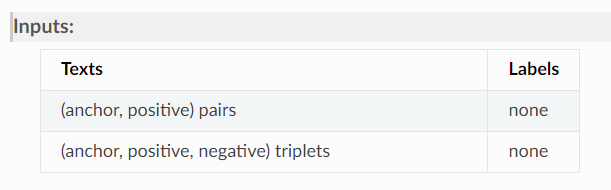

In [11]:
loss = losses.MultipleNegativesRankingLoss(model)


### Defing Evaluator

We setup an evaluator with our val split of the dataset to monitor how well the embedding model is performing during training.



In [12]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator


In [13]:
dataset = val_dataset

corpus = dataset['corpus']
queries = dataset['queries']
relevant_docs = dataset['relevant_docs']

evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs,write_csv=True)

In [14]:
results = evaluator(model)
results

{'cosine_accuracy@1': 0.5922330097087378,
 'cosine_accuracy@3': 0.8058252427184466,
 'cosine_accuracy@5': 0.8640776699029126,
 'cosine_accuracy@10': 0.912621359223301,
 'cosine_precision@1': 0.5922330097087378,
 'cosine_precision@3': 0.2686084142394822,
 'cosine_precision@5': 0.17281553398058247,
 'cosine_precision@10': 0.09126213592233007,
 'cosine_recall@1': 0.5922330097087378,
 'cosine_recall@3': 0.8058252427184466,
 'cosine_recall@5': 0.8640776699029126,
 'cosine_recall@10': 0.912621359223301,
 'cosine_ndcg@10': 0.7604451404913265,
 'cosine_mrr@10': 0.7108683926645092,
 'cosine_map@100': 0.7167491798131432,
 'dot_accuracy@1': 0.5922330097087378,
 'dot_accuracy@3': 0.8058252427184466,
 'dot_accuracy@5': 0.8640776699029126,
 'dot_accuracy@10': 0.912621359223301,
 'dot_precision@1': 0.5922330097087378,
 'dot_precision@3': 0.2686084142394822,
 'dot_precision@5': 0.17281553398058247,
 'dot_precision@10': 0.09126213592233007,
 'dot_recall@1': 0.5922330097087378,
 'dot_recall@3': 0.805825

### Run Training
The training loop is very straight forward to steup thanks to sentencetransformers' high-level model training API. All we need to do is plugging in the data loader, loss function, and evaluator that we defined in the previous cells (along with a couple of additional minor settings).

In [15]:
!pip3 install datasets -q -U


ERROR: Operation cancelled by user


In [ ]:
!pip install --upgrade pyarrow datasets -q

In [ ]:
!pip uninstall pyarrow datasets -y
!pip install pyarrow==14.0.1 datasets -q


Found existing installation: pyarrow 16.1.0
Uninstalling pyarrow-16.1.0:
  Successfully uninstalled pyarrow-16.1.0
Found existing installation: datasets 2.20.0
Uninstalling datasets-2.20.0:
  Successfully uninstalled datasets-2.20.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 54.4 MB/s eta 0:00:00


In [ ]:
!pip install accelerate -U -q

In [103]:
!pip install transformers[torch] -q

In [16]:
from datasets import Dataset

In [17]:
# We train the model for very few epochs in this toy example.
# This should typically be higher for better performance.
EPOCHS = 10

In [18]:
warmup_steps = int(len(loader) * EPOCHS)

In [19]:
model.fit(
    train_objectives=[(loader, loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    output_path='exp_finetune',
    show_progress_bar=True,
    evaluator=evaluator,
    # evaluation_steps=50,
)

Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100,Dot Accuracy@1,Dot Accuracy@3,Dot Accuracy@5,Dot Accuracy@10,Dot Precision@1,Dot Precision@3,Dot Precision@5,Dot Precision@10,Dot Recall@1,Dot Recall@3,Dot Recall@5,Dot Recall@10,Dot Ndcg@10,Dot Mrr@10,Dot Map@100
24,No log,No log,0.621359,0.825243,0.864078,0.912621,0.621359,0.275081,0.172816,0.091262,0.621359,0.825243,0.864078,0.912621,0.774720,0.729704,0.735184,0.621359,0.825243,0.864078,0.912621,0.621359,0.275081,0.172816,0.091262,0.621359,0.825243,0.864078,0.912621,0.774720,0.729704,0.735184
48,No log,No log,0.660194,0.834951,0.873786,0.902913,0.660194,0.278317,0.174757,0.090291,0.660194,0.834951,0.873786,0.902913,0.788038,0.750173,0.756387,0.660194,0.834951,0.873786,0.902913,0.660194,0.278317,0.174757,0.090291,0.660194,0.834951,0.873786,0.902913,0.788038,0.750173,0.756387
72,No log,No log,0.689320,0.825243,0.864078,0.922330,0.689320,0.275081,0.172816,0.092233,0.689320,0.825243,0.864078,0.922330,0.800941,0.762513,0.766896,0.689320,0.825243,0.864078,0.922330,0.689320,0.275081,0.172816,0.092233,0.689320,0.825243,0.864078,0.922330,0.800941,0.762513,0.766896
96,No log,No log,0.650485,0.815534,0.864078,0.932039,0.650485,0.271845,0.172816,0.093204,0.650485,0.815534,0.864078,0.932039,0.787510,0.741728,0.745560,0.650485,0.815534,0.864078,0.932039,0.650485,0.271845,0.172816,0.093204,0.650485,0.815534,0.864078,0.932039,0.787510,0.741728,0.745560
120,No log,No log,0.621359,0.796117,0.834951,0.932039,0.621359,0.265372,0.166990,0.093204,0.621359,0.796117,0.834951,0.932039,0.769201,0.718027,0.722499,0.621359,0.796117,0.834951,0.932039,0.621359,0.265372,0.166990,0.093204,0.621359,0.796117,0.834951,0.932039,0.769201,0.718027,0.722499
144,No log,No log,0.631068,0.805825,0.834951,0.941748,0.631068,0.268608,0.166990,0.094175,0.631068,0.805825,0.834951,0.941748,0.779138,0.728182,0.731874,0.631068,0.805825,0.834951,0.941748,0.631068,0.268608,0.166990,0.094175,0.631068,0.805825,0.834951,0.941748,0.779138,0.728182,0.731874
168,No log,No log,0.660194,0.805825,0.873786,0.941748,0.660194,0.268608,0.174757,0.094175,0.660194,0.805825,0.873786,0.941748,0.792808,0.746182,0.749850,0.660194,0.805825,0.873786,0.941748,0.660194,0.268608,0.174757,0.094175,0.660194,0.805825,0.873786,0.941748,0.792808,0.746182,0.749850
192,No log,No log,0.631068,0.786408,0.844660,0.932039,0.631068,0.262136,0.168932,0.093204,0.631068,0.786408,0.844660,0.932039,0.775190,0.725732,0.730150,0.631068,0.786408,0.844660,0.932039,0.631068,0.262136,0.168932,0.093204,0.631068,0.786408,0.844660,0.932039,0.775190,0.725732,0.730150
216,No log,No log,0.621359,0.786408,0.864078,0.932039,0.621359,0.262136,0.172816,0.093204,0.621359,0.786408,0.864078,0.932039,0.772086,0.721205,0.725438,0.621359,0.786408,0.864078,0.932039,0.621359,0.262136,0.172816,0.093204,0.621359,0.786408,0.864078,0.932039,0.772086,0.721205,0.725438
240,No log,No log,0.640777,0.815534,0.864078,0.932039,0.640777,0.271845,0.172816,0.093204,0.640777,0.815534,0.864078,0.932039,0.782592,0.735136,0.739785,0.640777,0.815534,0.864078,0.932039,0.640777,0.271845,0.172816,0.093204,0.640777,0.815534,0.864078,0.932039,0.782592,0.735136,0.739785


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

### checking the evaluation

In [22]:
results = evaluator(model)

In [23]:
print(results)

{'cosine_accuracy@1': 0.6407766990291263, 'cosine_accuracy@3': 0.8155339805825242, 'cosine_accuracy@5': 0.8640776699029126, 'cosine_accuracy@10': 0.9320388349514563, 'cosine_precision@1': 0.6407766990291263, 'cosine_precision@3': 0.2718446601941747, 'cosine_precision@5': 0.17281553398058247, 'cosine_precision@10': 0.09320388349514559, 'cosine_recall@1': 0.6407766990291263, 'cosine_recall@3': 0.8155339805825242, 'cosine_recall@5': 0.8640776699029126, 'cosine_recall@10': 0.9320388349514563, 'cosine_ndcg@10': 0.7825919037319005, 'cosine_mrr@10': 0.7351363846509477, 'cosine_map@100': 0.7397851339598912, 'dot_accuracy@1': 0.6407766990291263, 'dot_accuracy@3': 0.8155339805825242, 'dot_accuracy@5': 0.8640776699029126, 'dot_accuracy@10': 0.9320388349514563, 'dot_precision@1': 0.6407766990291263, 'dot_precision@3': 0.2718446601941747, 'dot_precision@5': 0.17281553398058247, 'dot_precision@10': 0.09320388349514559, 'dot_recall@1': 0.6407766990291263, 'dot_recall@3': 0.8155339805825242, 'dot_reca

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Sharing to the Hugging Face Hub

In [21]:
model.push_to_hub("bge-small-en-MultiplrRankingLoss-Tax-dataset")

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

'https://huggingface.co/Areeb-02/bge-small-en-MultiplrRankingLoss-Tax-dataset/commit/acaf2f4cb8fa5ad5e7e7ef7d53cf4bebd88113f4'

## CoSENTLoss

In [98]:
!pip install datasets -q -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [1]:
!pip uninstall pyarrow -y
!pip install pyarrow --upgrade  # Install the latest version of PyArrow
from datasets import Dataset

Found existing installation: pyarrow 16.1.0
Uninstalling pyarrow-16.1.0:
  Successfully uninstalled pyarrow-16.1.0
  Using cached pyarrow-16.1.0-cp310-cp310-manylinux_2_28_x86_64.whl (40.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [13]:
import json
from datasets import Dataset

from sentence_transformers import SentenceTransformer
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction

### preparing data

**classsentence_transformers**.losses.CoSENTLoss(model: sentence_transformers.SentenceTransformer.SentenceTransformer, scale: float = 20.0, similarity_fct=<function pairwise_cos_sim>)[source]
This class implements CoSENT (Cosine Sentence) loss. It expects that each of the InputExamples consists of a pair of texts and a float valued label, representing the expected similarity score between the pair.

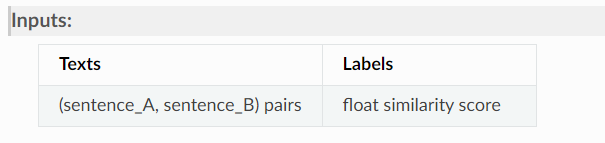

In [9]:
import json

from torch.utils.data import DataLoader
from sentence_transformers import InputExample

In [3]:
TRAIN_DATASET_FPATH = '/content/train_dataset.json'
VAL_DATASET_FPATH = '/content/eval_dataset_anchor-positive-similarity.json'




In [27]:
with open(TRAIN_DATASET_FPATH, 'r+') as f:
    train_dataset = json.load(f)

with open(VAL_DATASET_FPATH, 'r+') as f:
    val_dataset = json.load(f)

In [28]:
dataset = train_dataset
anchor_dict = dataset['anchors']
positives_dict = dataset['positives']
scores_dict = dataset['similarities']

anchor_sentences = []
positive_sentences = []
scores = []

examples = []
for anchor_id, anchor in anchor_dict.items():
    anchor_sentences.append(anchor)
    positive = positives_dict[anchor_id]
    positive_sentences.append(positive)

    similarity_score = float(scores_dict[anchor_id])
    scores.append(similarity_score)


train_dataset = Dataset.from_dict({
    "sentence1": anchor_sentences,
    "sentence2": positive_sentences,
    "score": scores,
})

In [11]:
BATCH_SIZE = 10
loader = DataLoader(
    examples, batch_size=BATCH_SIZE
)

### Loading Model

In [29]:
model_id = ('BAAI/bge-large-en-v1.5')
model = SentenceTransformer(model_id)


### EmbeddingSimilarityEvaluator dev

In [17]:
len(dataset['similarities'])

35

In [16]:
dataset = val_dataset
anchor_dict = dataset['anchors']
positives_dict = dataset['positives']
scores_dict = dataset['similarities']

sentences1 = []
sentences2 = []
scores = []

examples = []
for anchor_id, anchor in anchor_dict.items():
    sentences1.append(anchor)
    positive = positives_dict[anchor_id]
    sentences2.append(positive)

    similarity_score = float(scores_dict[anchor_id])
    scores.append(similarity_score)


In [18]:
# Initialize the evaluator
dev_evaluator = EmbeddingSimilarityEvaluator(
    sentences1=sentences1,
    sentences2=sentences2,
    scores=scores,
    main_similarity=SimilarityFunction.COSINE,
    # name="sts-dev",
)

Evaluation before finetuning

In [19]:
dev_evaluator(model)

{'pearson_cosine': 0.3250565550447825,
 'spearman_cosine': 0.35694451258747584,
 'pearson_manhattan': 0.3221738049140614,
 'spearman_manhattan': 0.3517846004157181,
 'pearson_euclidean': 0.32235730040181065,
 'spearman_euclidean': 0.35694451258747584,
 'pearson_dot': 0.32505652699259124,
 'spearman_dot': 0.35694451258747584,
 'pearson_max': 0.3250565550447825,
 'spearman_max': 0.35694451258747584}

### Finetuning embedding model

In [20]:
from sentence_transformers import SentenceTransformer, SentenceTransformerTrainer, losses


#### importing loss

In [30]:
loss = losses.CoSENTLoss(model)

In [31]:
# We train the model for very few epochs in this toy example.
# This should typically be higher for better performance.
EPOCHS = 10

In [32]:
warmup_steps = int(len(loader) * EPOCHS)

#### Sentence Transformer Training Arguments

In [37]:
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="modelBAAI/bge-large-en-v1.5",
    # Optional training parameters:
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    fp16=True,  # Set to False if GPU can't handle FP16
    bf16=False,  # Set to True if GPU supports BF16
    # batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicates
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    # eval_steps=100,
    # save_strategy="steps",
    # save_steps=100,
    # save_total_limit=2,
    # logging_steps=100,
    # run_name="mpnet-base-all-nli-triplet",  # Used in W&B if `wandb` is installed
)

In [39]:
trainer = SentenceTransformerTrainer(
    model=model,
    train_dataset=train_dataset,
    loss=loss,
    args=args,
    evaluator=dev_evaluator,
)
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=45, training_loss=2.775104268391927, metrics={'train_runtime': 52.9371, 'train_samples_per_second': 12.468, 'train_steps_per_second': 0.85, 'total_flos': 0.0, 'train_loss': 2.775104268391927, 'epoch': 5.0})

### Evaluation again after training

In [40]:
dev_evaluator(model)

{'pearson_cosine': 0.3338547038124495,
 'spearman_cosine': 0.41279297374061835,
 'pearson_manhattan': 0.3102979152053135,
 'spearman_manhattan': 0.41673878893078603,
 'pearson_euclidean': 0.30953937257079917,
 'spearman_euclidean': 0.41279297374061835,
 'pearson_dot': 0.3338548430968143,
 'spearman_dot': 0.41279297374061835,
 'pearson_max': 0.3338548430968143,
 'spearman_max': 0.41673878893078603}

## Sharing a Sentence Transformers to the Hugging Face Hub

In [41]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineGrained).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your termin

In [ ]:
# 6. Save the trained model and optionally push it to the Hugging Face Hub
model.save_pretrained("modelBAAI/bge-large-en-v1.5-cosentLoss/final")


In [43]:
model.push_to_hub("bge-large-en-v1.5-CosentLoss")

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

'https://huggingface.co/Areeb-02/bge-large-en-v1.5-CosentLoss/commit/d7f1727f40b89a55e3b675786798cc18977a463d'